In [1]:
from edc import check_compatibility
check_compatibility("user-2021.12", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


# Exploring Time and Space: A guide to accessing, analysing and visualising data in the Euro Data Cube
---
Written by: _William Ray_

## Getting started with EDC

In this demonstration Jupyter Notebook, we will be visualising and analysing river flooding using Sentinel data to demonstrate how you can use EDC for your own applications. Much of what we we will focus on can be used for many other applications and use cases. 

We are going to use the EDC and its associated libaries and APIs to do this. In this notebook we will learn how to:

- Build a cube
- Visualise a variable in your data cube
- Create a new variable
- Create a new variable using a threshold
- Visualise a spatial subset of a variable over time
- Create a new variable based upon space and time. 

## Configuration

Before acccessing the data, we will start by importing the necessary Python libraries (already configured in your EDC workspace), and generate credentials automatically to access the services.

In [2]:
# EDC libraries
from edc import setup_environment_variables
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub
from xcube.core.gen2.local.combiner import CubesCombiner
from xcube.core.geom import mask_dataset_by_geometry

# Sentinel Hub
from sentinelhub import BBox, SentinelHubRequest, bbox_to_dimensions, DataCollection, MimeType, SHConfig, geometry

# Utilities
import IPython.display
from os import environ
import matplotlib.pyplot as plt
import datetime as dt
import geopandas
import rioxarray

# Numerical computation
import xarray as xr
import numpy as np

# Fetch credentials as environement variables
setup_environment_variables()

# Pass Sentinel Hub credentials to dictionnary
sh_credentials = dict(client_id=environ["SH_CLIENT_ID"],
                      client_secret=environ["SH_CLIENT_SECRET"])

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:

The following additional environment variables have been loaded from `~/custom.env`:
* `AWS_BUCKET`
* `DAPA_URL`
* `DB_HOST`, `DB_NAME`, `DB_PASSWORD`, `DB_USER`
* `OGC_EDC_URL`
* `REFERENCE_DATA`


***Define an AOI***

Next, we will define our area of interest using a bounding box. This must be provided in WGS84 coordinates to build the cube. But later, we will clip this further using a GeoJSON to a far better defined AOI. We have chosen an AOI on the River Severn in the UK. This area regularly floods in the winter months with a wide floodplain. Last winter (2020/2021), there was significant flooding in the second half of December and at the end of January / start of February. 

In [3]:
# Bbox
tewkesbury_uk_bbox = [-2.24, 51.93, -2.09, 52.10]
smaller_box = [-2.24, 51.99, -2.15, 52.05]

# Bbox EPSG
bbox_epsg = 4326

In [4]:
# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(smaller_box,crs=bbox_epsg).get_geojson())

<IPython.display.GeoJSON object>

### How to build a data cube

Firstly, we will go through how to build a data cube.

We are going to visualise the floods using Sentinel-2 imagery. Sentinel-2 is part of the Copernicus programme and collects multispectral data globally with a revisit time of 5 days. The satellite's multispectral imager provides collects data in 13 spectral bands spanning from the visible and near infrared to the shortwave infrared. The visible and near infrared data we will use in this example is collected at 10m resolution. 

***Check Sentinel-2 L2A available bands***

Using EDC inbuilt functions that query Sentinel Hub services, we can easily list the available bands for a given dataset to help us build the cube! 

In [5]:
# Create a Sentinel Hub class, using our Sentinel Hub credentials
SH = SentinelHub(**sh_credentials)

# List bands for S2-L2A
SH.band_names('S2L2A')

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12',
 'SCL',
 'SNW',
 'CLD',
 'viewZenithMean',
 'viewAzimuthMean',
 'sunZenithAngles',
 'sunAzimuthAngles',
 'AOT',
 'CLM',
 'CLP']

***Build an xcube***

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `S2L2A` for Sentinel-2 L2A. All available datasets can be listed with `SH.dataset_names`

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call the B02, B03, B04, B08, CLM (Blue, Green, Red & NIR, Cloud Mask) bands.

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set.

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 10 meters, we set the resolution to 0.000089 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. Sentinel-2 L2A data is available from October 2016 onwards. In this example, we will fetch data for December 2020 - February 2021.

- _time_tolerance_: The tolerance used to identify whether a dataset should still be included within a time period. Here, `30M` corresponds to 30 minutes, thus avoiding duplicate datasets.

_Note: the `return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)` warning can be safely ignored._

In [6]:
# Setup xcube
s2_cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B02', 'B03', 'B04', 'B08', 'CLM'],
                         bbox=smaller_box,
                         spatial_res=0.000089,
                         time_range=['2020-12-01', '2021-02-28'],
                         time_tolerance='30M')

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:142: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


***Open the xcube***

In the following cell we open the cube and display its contents. The automatically generated credentials obtained earlier in this Jupyter Notebook are specified as a parameter when opening the cube. It's important to note that at this stage, we're not processing anything, just generating a cube on the fly with data ready to be called when needed for analysis.

Once you open the cube, you can visualise the contents. You can view the number of timestamps and a list of them all too in the Coordinates tab. You can also visualise the seperate variables, with information on the size of the variables and their data type too.  

In [7]:
# Open cube (on the fly)
s2_cube = open_cube(s2_cube_config, **sh_credentials)

# Display contents
s2_cube

<xarray.Dataset>
Dimensions:    (time: 34, lat: 674, lon: 1011, bnds: 2)
Coordinates:
  * lat        (lat) float64 52.05 52.05 52.05 52.05 ... 51.99 51.99 51.99 51.99
  * lon        (lon) float64 -2.24 -2.24 -2.24 -2.24 ... -2.15 -2.15 -2.15 -2.15
  * time       (time) datetime64[ns] 2020-12-02T11:16:51 ... 2021-02-25T11:16:50
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(34, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 674, 1011), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 674, 1011), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 674, 1011), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 674, 1011), meta=np.ndarray>
    CLM        (time, lat, lon) float32 dask.array<chunksize=(1, 674, 1011), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2021-12-14T12:52:39.149925
    time_coverage_start:     2020-12-02T11:16:51+00:00
    time_coverage_end:       2021-02-25T11:16:50+00:00
    time_coverage_duration:  P84DT23H59M59S
    geospatial_lon_min:      -2.24
    geospatial_lat_min:      51.99
    geospatial_lon_max:      -2.150021
    geospatial_lat_max:      52.049986000000004
    processing_level:        L2A

### How to visualise your datacube

Now we have built our cube, let's visualise the data! We are going to visualise a True Color image and an NDWI image in the same plot. In the below cell you can see we are selecting each band for 10:00:00 28th December 2020, and selecting the nearest acquisition to this date and time. We then stack the three bands and plot this using Matplotlib. We will call the three bands in the visible spectrum. In addition we will multiply the reflectance values by 3 to brighten the image due to the acquisition we're visualising being acquired in the winter months.

Another way to visualise the extent of surface water is to use the Normalised Difference Water Index (NDWI). This is an index that can be used to extract surface water using multispectral imagery such as Sentinel-2. We can calculate the index with the Green and NIR bands as stated below, and add it into the data cube as a new variable.

NDWI = Green - NIR / Green + NIR

For this we are going to create a new variable in the next cell. To create the new variable we are using two existing variables defined as s2.cube.B03 and s2_cube.B08. We then insert these variables into an index formula to create NDWI. Once ndwi has been calculated it's attributed a long_name and units before being defined as ndwi so that we can call it as a definition later in the notebook.

In [8]:
# Define NDWI in visualisation
ndwi = ((s2_cube.B03-s2_cube.B08)/(s2_cube.B03+s2_cube.B08))

ndwi.attrs['long_name']='NDWI'
ndwi.attrs['units']='unitless'

s2_cube['NDWI']= ndwi  

Next we want to plot both the True Color image and the NDWI in the same plot. We will use Matplotlib to achieve this. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


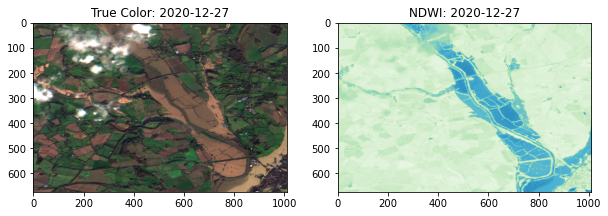

In [9]:
# Select the bands and stack them.
Red = s2_cube.B04.sel(time='2020-12-28 10:00:00', method='nearest')
Green = s2_cube.B03.sel(time='2020-12-28 10:00:00', method='nearest')
Blue = s2_cube.B02.sel(time='2020-12-28 10:00:00', method='nearest')

rgb = np.dstack((Red,Green,Blue)) #Stack the three arrays

ndwi = s2_cube.NDWI.sel(time='2020-12-28 10:00:00', method='nearest')

# Plot 
f = plt.figure(figsize=[10, 15])
f.add_subplot(1, 2, 1)
plt.title(f"True Color: {str(s2_cube.time.sel(time='2020-12-28 10:00:00', method='nearest').data).split('T')[0]}")
plt.imshow(5 * rgb)  # We multiply the rgb by 5 to make the image brighter
f.add_subplot(1, 2, 2)
plt.title(f"NDWI: {str(s2_cube.time.sel(time='2020-12-28 10:00:00', method='nearest').data).split('T')[0]}")
plt.imshow(ndwi, vmin=-1, vmax=1, cmap='GnBu')
plt.show()

This looks good, and the extent of the flood waters is visualised really nicely here. The 10m resolution also enables us to see individual fields that are flooded with the linear boundaries of the fields highlighted nicely in the high resolution image provided by the 10m Sentinel 2 bands. This looks really useful so let's try and visualise some more dates in the time period that we are examining; 

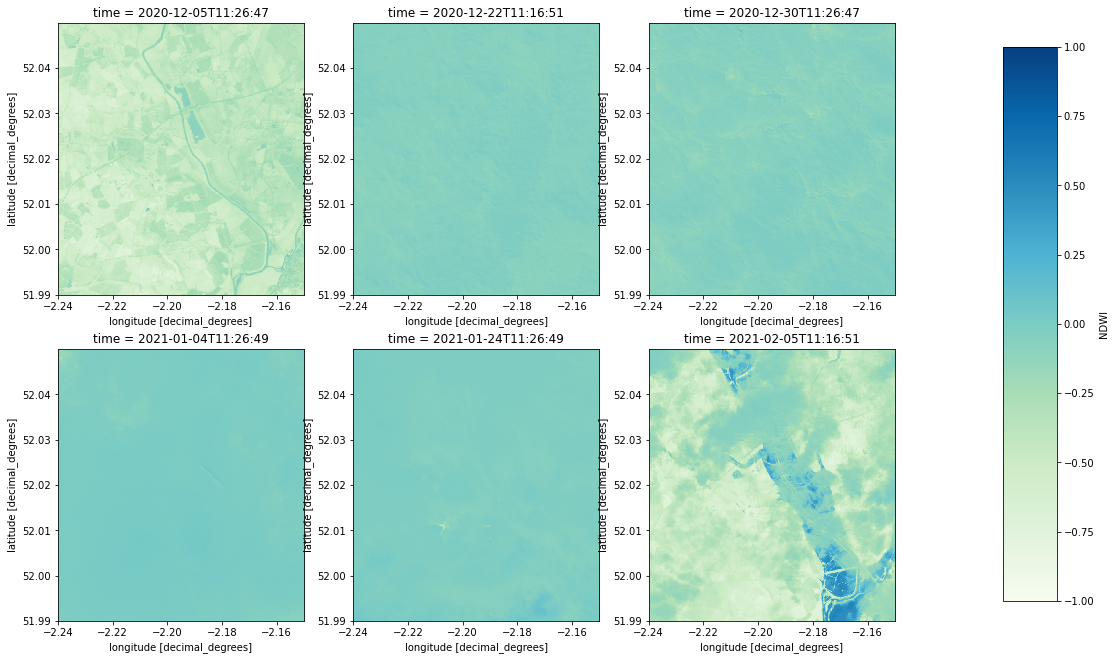

In [10]:
# Select timestamps
ndwi1 = s2_cube.NDWI.sel(time='2020-12-05 10:00:00', method='nearest')
ndwi2 = s2_cube.NDWI.sel(time='2020-12-24 10:00:00', method='nearest')
ndwi3 = s2_cube.NDWI.sel(time='2020-12-31 10:00:00', method='nearest')
ndwi4 = s2_cube.NDWI.sel(time='2021-01-05 10:00:00', method='nearest')
ndwi5 = s2_cube.NDWI.sel(time='2021-01-24 10:00:00', method='nearest')
ndwi6 = s2_cube.NDWI.sel(time='2021-02-05 10:00:00', method='nearest')


# Plot 
f = plt.figure(figsize=[15,11])
ax1 = f.add_subplot(2,3, 1)
ax2 = f.add_subplot(2,3, 2)
ax3 = f.add_subplot(2,3, 3)
ax4 = f.add_subplot(2,3, 4)
ax5 = f.add_subplot(2,3, 5)
ax6 = f.add_subplot(2,3, 6)

axlist=[ax1,ax2,ax3,ax4,ax5,ax6]

t = ndwi1.plot.imshow(ax=ax1, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi2.plot.imshow(ax=ax2, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi3.plot.imshow(ax=ax3, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi4.plot.imshow(ax=ax4, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi5.plot.imshow(ax=ax5, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi6.plot.imshow(ax=ax6, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)

cbar_ax = f.add_axes([1, 0.15, 0.05, 0.7])
f.colorbar(t, cax=cbar_ax, label="NDWI")

plt.show()

This is not so useful! Unsurprisingly, in a maritime climate most of the images are cloudy and of no use to flood monitoring. Of the six dates we have requested, only one is fully cloud free and four of the dates are unusable. From the limited data we have, we know the river was in its normal state on 5th December and in flood on 5th February but due to cloud cover we don't know what is happening in between those dates. This problem is very common in the UK where cloud cover is extremely common during the winter months, meaning you are almost certain to have incomplete time series of data. Fortunately, there is a solution we can use, thanks to the Sentinel-1 platform. 

### Sentinel-1 description

Like Sentinel-2, Sentinel-1 is also part of the Copernicus programme and collects data globally with a revisit time of 5 days. In contrast to Sentinel-2, Sentinel-1 SAR is an active sensor using SAR signals recording the backscatter. Due to the wavelengths used, SAR is not hindered by clouds and can be operated day and night. 

### Check Sentinel-1 GRD available bands

Using EDC inbuilt functions that query Sentinel Hub services, we can easily list the available bands for a given dataset. 

In [11]:
# List bands for S1-GRD
SH.band_names('S1GRD')

['VV', 'HH', 'VH', 'localIncidenceAngle', 'scatteringArea', 'shadowMask', 'HV']

### Build an xcube

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `S1GRD` for Sentinel-1 GRD. All available datasets can be listed with `SH.dataset_names`

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call just the VV polarisation band.

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set.

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 10 meters, we set the resolution to 0.000089 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. Sentinel-1 GRD data is available from February 2015 onwards. In this example, we will fetch data for December 2020 - February 2021.

- _time_tolerance_: The tolerance used to identify whether a dataset should still be included within a time period. Here, `30M` corresponds to 30 minutes, thus avoiding duplicate datasets.

_Note: the `return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)` warning can be safely ignored._

In [12]:
# Setup xcube
s1_cube_config = CubeConfig(dataset_name='S1GRD',
                         band_names=['VV'],
                         bbox=smaller_box,
                         spatial_res=0.000089,
                         time_range=['2020-12-01', '2021-02-28'],
                         time_tolerance='30M')

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:142: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


### Open the xcube

In the following cell we open the cube and display its contents. The automatically generated credentials obtained earlier in this Jupyter Notebook are specified as a parameter when opening the cube.

In [13]:
# Open cube (on the fly)
s1_cube = open_cube(s1_cube_config, **sh_credentials)

# Display contents
s1_cube

<xarray.Dataset>
Dimensions:    (time: 44, lat: 674, lon: 1011, bnds: 2)
Coordinates:
  * lat        (lat) float64 52.05 52.05 52.05 52.05 ... 51.99 51.99 51.99 51.99
  * lon        (lon) float64 -2.24 -2.24 -2.24 -2.24 ... -2.15 -2.15 -2.15 -2.15
  * time       (time) datetime64[ns] 2020-12-01T06:22:31 ... 2021-02-27T17:49:53
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(44, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    VV         (time, lat, lon) float32 dask.array<chunksize=(1, 674, 1011), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S1GRD Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2021-12-14T12:53:00.152175
    time_coverage_start:     2020-12-01T06:22:19+00:00
    time_coverage_end:       2021-02-27T17:49:53+00:00
    time_coverage_duration:  P88DT11H27M34S
    geospatial_lon_min:      -2.24
    geospatial_lat_min:      51.99
    geospatial_lon_max:      -2.150021
    geospatial_lat_max:      52.049986000000004
    processing_level:        L1B

### Visualising the flooded areas using SAR

We are going to use the VV band to visualise the flooding. From our earlier visualisation, we know that there was significant surface water flooding just after Christmas 2020 so will select the same date as last time, but as this is a different sensor we will expect an acquisition from a different date. 

Firstly, we need to generate a new variable. In GRD data the VV polarisation is provided in Digital Number format and to perform some analysis we need to convert this to decibels. This is done by mutiplying the log10 of each DN pixel by 10. Secondly, as there will be pixels with a value of -inf after this operation, we need to account for this with the second function which will automatically assign 0 to these pixels. 

In [14]:
# Convert VV Digital numbers to Decibels
vv_dn = s1_cube.VV
vv_db = 10 * (xr.ufuncs.log10(vv_dn))

vv_db = vv_db.where(xr.ufuncs.isfinite(vv_db), 0)

vv_db.attrs['long_name']='VV_dB'
vv_db.attrs['units']='decibels'

s1_cube['VV_dB']= vv_db

/tmp/ipykernel_5424/3424313115.py:3: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  vv_db = 10 * (xr.ufuncs.log10(vv_dn))
/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/xarray/core/dataarray.py:3066: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))
/tmp/ipykernel_5424/3424313115.py:5: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  vv_db = vv_db.where(xr.ufuncs.isfinite(vv_db), 0)
/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/xarray/core/dataarray.py:3066: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


Like previously, we are going to visualise the `VV_dB` variable we have just generated for our AOI. 

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


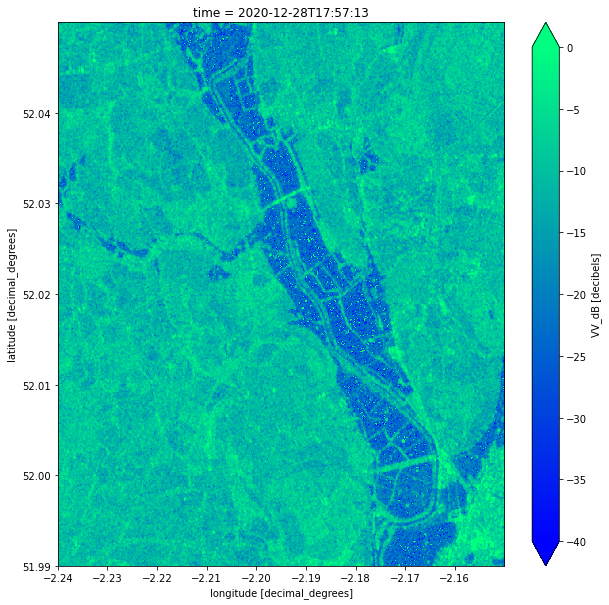

In [15]:
# select and define the timestamp you want to visualise 
VV_dB_timestamp = s1_cube.VV_dB.sel(time='2020-12-28 10:00:00', method='nearest')

# plot the timestamp
VV_dB_timestamp.plot.imshow(vmin=-40, vmax=0, cmap='winter', figsize=(10, 10))

# save and display the plot
plt.show()

This looks very similar to the NDWI we derived earlier showing the flood extent fairly clearly (the blue areas). It looks fairly well defined so let's visualise the same but over several timestamps to confirm that this is a good variable to use to generate a flood mask. 

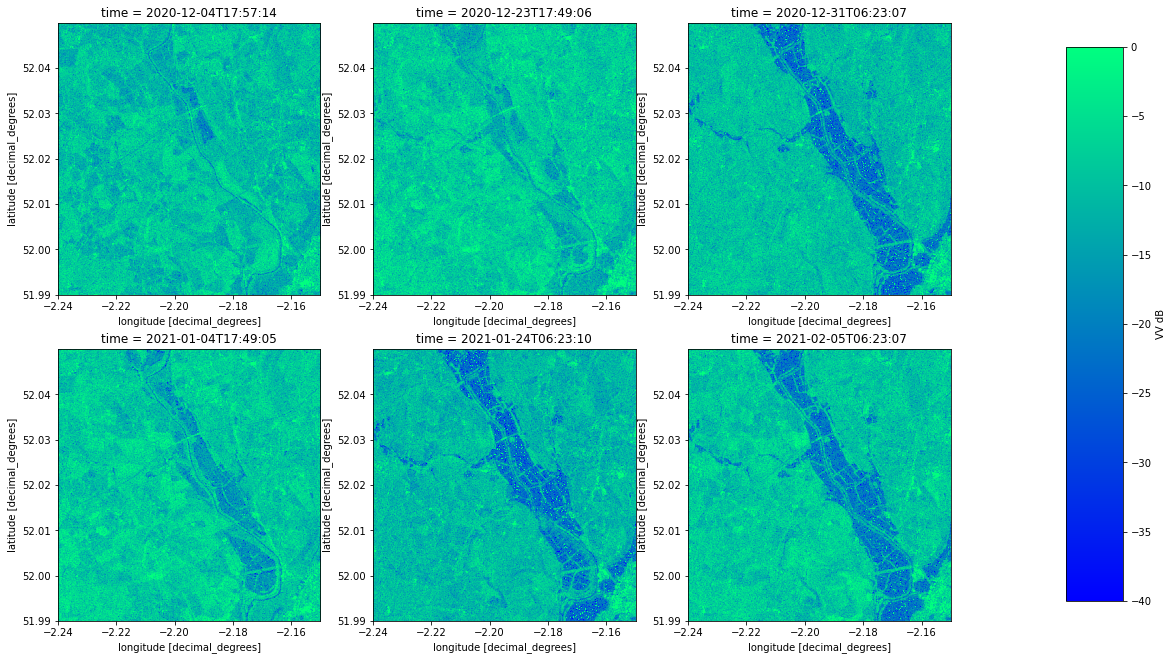

In [16]:
#### Timestamp selection
vv1 = s1_cube.VV_dB.sel(time='2020-12-05 10:00:00', method='nearest')
vv2 = s1_cube.VV_dB.sel(time='2020-12-24 10:00:00', method='nearest')
vv3 = s1_cube.VV_dB.sel(time='2020-12-31 10:00:00', method='nearest')
vv4 = s1_cube.VV_dB.sel(time='2021-01-05 10:00:00', method='nearest')
vv5 = s1_cube.VV_dB.sel(time='2021-01-24 10:00:00', method='nearest')
vv6 = s1_cube.VV_dB.sel(time='2021-02-05 10:00:00', method='nearest')

# Plot 
f = plt.figure(figsize=[16,11])
ax1 = f.add_subplot(2,3, 1)
ax2 = f.add_subplot(2,3, 2)
ax3 = f.add_subplot(2,3, 3)
ax4 = f.add_subplot(2,3, 4)
ax5 = f.add_subplot(2,3, 5)
ax6 = f.add_subplot(2,3, 6)

axlist=[ax1,ax2,ax3,ax4,ax5,ax6]

t = vv1.plot.imshow(ax=ax1, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv2.plot.imshow(ax=ax2, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv3.plot.imshow(ax=ax3, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv4.plot.imshow(ax=ax4, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv5.plot.imshow(ax=ax5, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv6.plot.imshow(ax=ax6, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)

cbar_ax = f.add_axes([1, 0.15, 0.05, 0.7])
f.colorbar(t, cax=cbar_ax, label="VV dB")

plt.show()

This gives a much clearer picture of flooding during the time period than using NDWI, and we now know much more about the spatial and temporal extent of the flooding in the AOI in the winter of 2020/2021. Next we want to generate a flood mask using a threshold. Generally, as a good rule of thumb; in the VV band, values below -20 dB are usually surface water. We will try this value first, but we will also look to visualise how the flood mask changes if we adjust the threshold value. First, let's generate the new variable using the .where function in xarray.

At first glance, the below cell may not make much sense. It may read that the step 1 function as assigning a value of 1 to pixels in VV_dB that are equal or more than -20. However, what is actually happening is that the .where function preserves all the pixel values in the variable that are below -20 and assigns everything else a value of 1. More can be found in the xarray documentation http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html 

In [17]:
# Assign all pixels equal or smaller than -20 a value of 1 and preserve the values of pixels 
step1 = s1_cube.VV_dB.where(s1_cube.VV_dB >= -20, 1)

# Assign all other pixels a value of 0. 
flooded = step1.where(step1 == 1, 0)

flooded.attrs['long_name'] ='flooded'
flooded.attrs['units'] ='nounits'

s1_cube['flooded'] = flooded

Next let's see what happens the the flood mask extent, if we change the threshold to -15 dB and -25dB:

In [18]:
flood_threshold1_step1 = s1_cube.VV_dB.where(s1_cube.VV_dB >= -15, 1)
flood_threshold2_step1 = s1_cube.VV_dB.where(s1_cube.VV_dB >= -20, 1)
flood_threshold3_step1 = s1_cube.VV_dB.where(s1_cube.VV_dB >= -25, 1)

flood_threshold1_step2 = flood_threshold1_step1.where(flood_threshold1_step1 == 1, 0)
flood_threshold2_step2 = flood_threshold2_step1.where(flood_threshold2_step1 == 1, 0)
flood_threshold3_step2 = flood_threshold3_step1.where(flood_threshold3_step1 == 1, 0)

flood_threshold1 = flood_threshold1_step2.sel(time='2020-12-28 10:00:00', method='nearest')
flood_threshold2 = flood_threshold2_step2.sel(time='2020-12-28 10:00:00', method='nearest')
flood_threshold3 = flood_threshold3_step2.sel(time='2020-12-28 10:00:00', method='nearest')

Next we will plot the new thresholds we want to test:

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


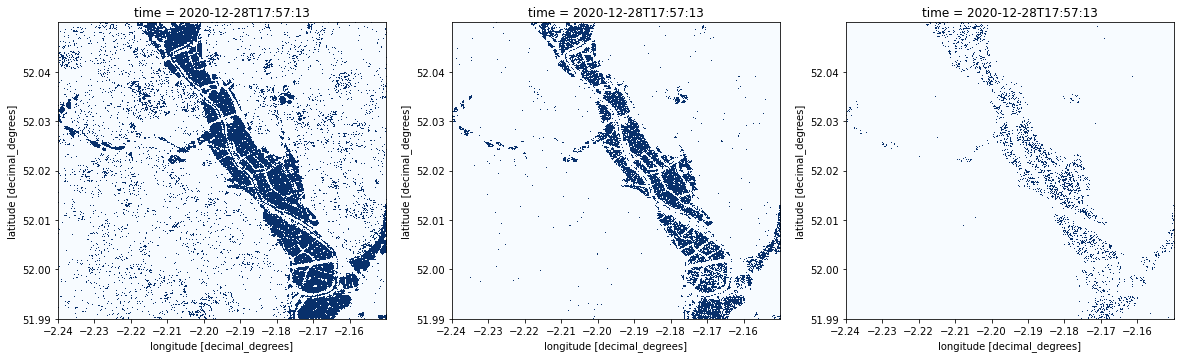

In [19]:
# Plot 
f = plt.figure(figsize=[20,12])
ax1 = f.add_subplot(2,3, 1)
ax2 = f.add_subplot(2,3, 2)
ax3 = f.add_subplot(2,3, 3)

flood_threshold1.plot.imshow(ax=ax1, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
flood_threshold2.plot.imshow(ax=ax2, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
flood_threshold3.plot.imshow(ax=ax3, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)

plt.show()

Changing the threshold by only 5 dB makes a large difference. If we set it as a higher number we pick up a lot more false positives and with a lower threshold we start to create more false negatives and a more fragmented flood extent. For now, let's use -20 dB as the threshold. Let's extrapolate our threshold out to a few more dates and see how this looks: 

Excellent, this looks like a good threshold across time and space. Let's move on to visualising the data from the temporal point of view.

### Plotting Time Series

***How to generate a time series plot for a point***

Excellent, we are getting a really good picture of how the flooding evolved over space and time. Now let's generate a time series for a Longitude and Latitude within the AOI and observe how NDWI and then VV_dB variables in the cubes compare over time. Firstly, we define the point_lat and point_lon and then using these as inputs we select the variable accross all the timesteps and to recieve the timeseries use the .to_series() function. It's at this point too that we use the CLM variable to mask out cloudy areas from the Sentinel 2 acquisitions in the time steps. 

In [20]:
# Set latitude and longitude of point to query
point_lat = 52.000089
point_lon = -2.167874

# Get timeseries
masked = s2_cube.NDWI.where(s2_cube.CLM == 0)
timeseriesNDWI_masked = masked.sel(lat=point_lat, lon=point_lon, method='nearest').to_series()
timeseriesNDWI_masked = timeseriesNDWI_masked.where(timeseriesNDWI_masked !=0).dropna()

timeseriesNDWI = s2_cube.NDWI.sel(lat=point_lat, lon=point_lon, method='nearest').to_series()
timeseriesNDWI = timeseriesNDWI.where(timeseriesNDWI !=0).dropna()

timeseriesVV_dB = s1_cube.VV_dB.sel(lat=point_lat, lon=point_lon, method='nearest').to_series()
timeseriesVV_dB = timeseriesVV_dB.where(timeseriesVV_dB !=0).dropna()

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


Using matplotlib we can now visualise how NDWI changes over time. In the plot we will plot 2 series, a cloud-masked series in blue, and an unmasked series in grey. 

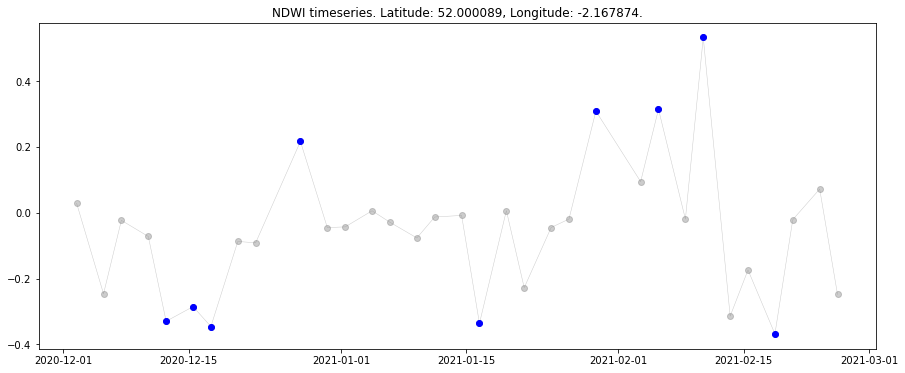

In [21]:
# Plot NDWI timeseries
_, ax = plt.subplots(1, figsize=(15, 6))
ax.plot(timeseriesNDWI, color="Grey", marker="o", linewidth=0.5, alpha=0.4)
ax.plot(timeseriesNDWI_masked, color="blue", linestyle="none", marker="o", linewidth=0.5)
ax.set_title(f"NDWI timeseries. Latitude: {point_lat}, Longitude: {point_lon}.")
plt.show()

The NDWI time series for Sentinel-2 doesn't really show us anything significant. There is no farily consistent NDWI value to go from which makes it difficult to establish a point of reference. There are peaks in NDWI at the end of December and the start of February but as was demonstrated earlier cloud cover is a big issue. There are big gaps between non-cloudy acquisitions of over a month in some cases. Let's plot the same but for the VV polarisation from Sentinel-1. 

***Plot VV dB timeseries for a given location***

We can now visualise how VV dB changes over time.

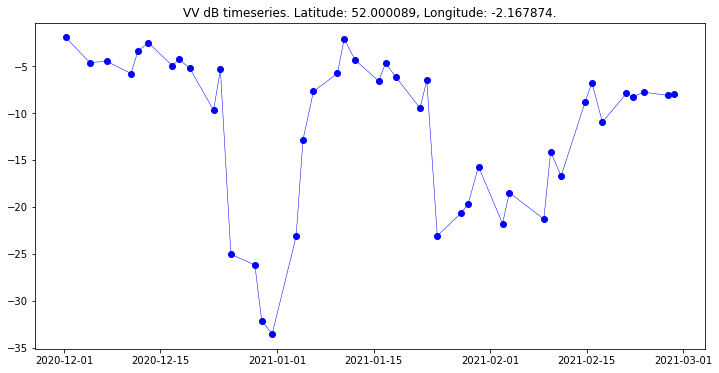

In [22]:
# Plot VV_dB timeseries
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(timeseriesVV_dB, color="blue", marker="o", linewidth=0.5)
ax.set_title(f"VV dB timeseries. Latitude: {point_lat}, Longitude: {point_lon}.")
plt.show()

This is much clearer than the Sentinel 2 time series as we have more observations due to no interference from cloud cover. We have a clear point of reference for what the VV polarisation response is during flood and non flooded time periods with a VV response of -8 to 0 dB when dry and < -20 dB when flooded. The time series really clearly shows the two flood events at the end of December / start of January and the end of January / start of February. 

***Plot VV dB timeseries for a given field or AOI***

Let's take this another step further, and generate the time series using a polygon instead of a point. First we have already generated a GeoJSON of a field on the banks of the River Severn near Tewkesbury. This field is part of the floodplain so we should see the flood peak again from the data. First let's import the GeoJSON and visualise it:

In [23]:
# Plot the bounding box on a map

field = {
    "type": "Polygon",
        "coordinates": [
          [
            [
              -2.164928913116455,
              52.00127710606571
            ],
            [
              -2.1648645401000977,
              52.00164699252238
            ],
            [
              -2.166323661804199,
              52.00146204967612
            ],
            [
              -2.1764731407165527,
              52.00024669196227
            ],
            [
              -2.175872325897217,
              51.9993087302974
            ],
            [
              -2.175271511077881,
              51.9974195365859
            ],
            [
              -2.1735334396362305,
              51.99625691621346
            ],
            [
              -2.170572280883789,
              51.995556687103125
            ],
            [
              -2.166731357574463,
              51.996336186743406
            ],
            [
              -2.165207862854004,
              51.998027257946404
            ],
            [
              -2.164928913116455,
              52.00127710606571
            ]
          ]
        ]}

IPython.display.GeoJSON(field)

<IPython.display.GeoJSON object>

Next, let's mask our dataset by the field we have just defined and visualise our 'masked' datacube. You can see that the variables we calculated have been generated and carried across into the new datacube.

In [24]:
water_meadow = mask_dataset_by_geometry(s1_cube, geometry=field)

Let's visualise our masked data cube using the first timestep and the VV_dB variable:

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


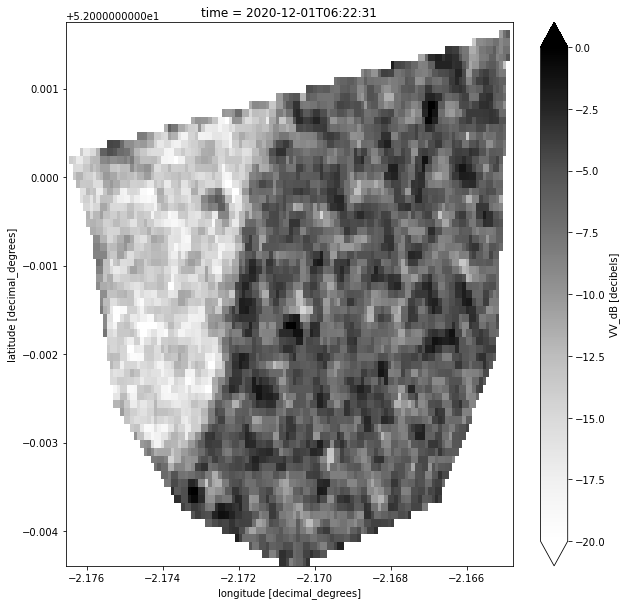

In [25]:
water_meadow.VV_dB.isel(time=0).plot.imshow(cmap='Greys', vmin=-20, vmax=0, figsize=(10, 10))
plt.show()

OK, this looks good, now we are now going to calculate the mean VV dB polarisation across the field for each time step. Firstly, we want to calculate the mean VV_dB on axis 1 (lat) and 2 (lon). The second function removes any observations with values of 0 (observations that don't cover our field of interest). Visualising this array we have 59 timesteps each assigned the mean value of the field.

In [26]:
# calculate the mean VV dB for each time step
timeseriesVV_dB = water_meadow.VV_dB.mean(axis=(1,2), skipna=True)

# remove any observations with no data
timeseriesVV_dB = timeseriesVV_dB.where(timeseriesVV_dB !=0).dropna("time")

# return the new data cube chunk
timeseriesVV_dB

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray 'VV_dB' (time: 44)>
dask.array<where, shape=(44,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-12-01T06:22:31 ... 2021-02-27T17:49:53

Next we can plot this new array we have generated. The result is an excellent picture showing the two flood events that occured in the time period. We can see the larger picture as this is the mean value over several pixels rather than just a single point like we previously plotted. 

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


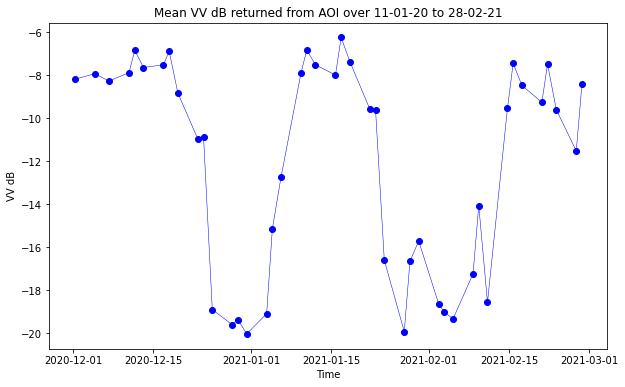

In [27]:
# Plot VV_dB timeseries
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(timeseriesVV_dB.time, timeseriesVV_dB, color="blue", marker="o", linewidth=0.5)
ax.set_title("Mean VV dB returned from AOI over 11-01-20 to 28-02-21")
ax.set_xlabel('Time')
ax.set_ylabel('VV dB')
plt.show()

### Creating advanced variables

**Mapping flooding frequency across the whole AOI**

Lastly, we are going to return to the full data cube and study area, and we are going to calculate the number of observations that each pixel is flooded during the time period we are examining by calculating the sum of the flood mask pixels. This will create an array with the number of observations a pixel was flooded assigned to each pixel.

Secondly, as using the absolute value makes comparisons with other time periods / areas difficult we will also calculate the proportion of observations that a pixel was flooded. To calculate this, we can then divide the sum of the flooded pixels by the number of timesteps in our data cube (the count). 

In [28]:
flood_sum = s1_cube.flooded.sum(dim="time")
flood_count = s1_cube.flooded.count(dim="time")
flood_average = flood_sum / flood_count

#flood_sum.attrs['long_name']='flood_sum'
#flood_sum.attrs['units']='nounits'

#s1_cube['flood_sum']= flood_sum

flood_average.attrs['long_name']='flood_average'
flood_average.attrs['units']='nounits'

s1_cube['flood_average']= flood_average

Now let's plot the flood_average into a plot:

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


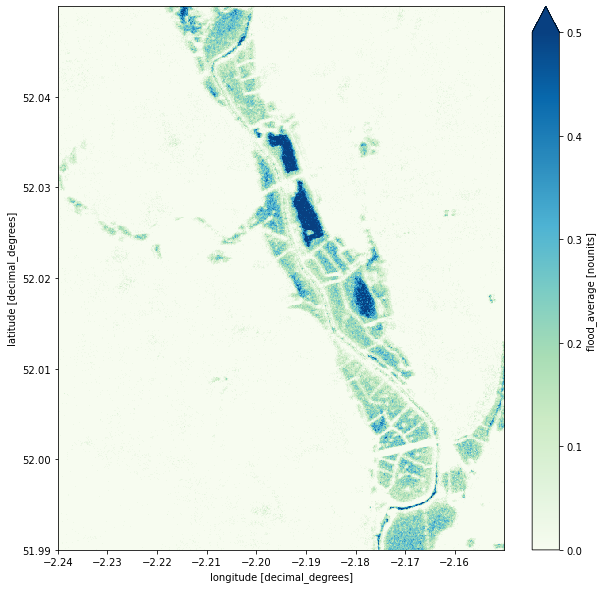

In [29]:
flood_average.plot.imshow(cmap='GnBu', vmin=0, vmax=0.5, figsize=(10, 10))
plt.show()

This looks great, we have identified the flood plain very clearly here and can also identify some areas that are more susceptible to flooding than others. 

### Export a variable to GeoTiff

Finally we will export some of the variables we have generated in this notebook. This is really easy to do and is shown in the next cell:

In [30]:
# define the timestep you wish to export
timestep = flood_threshold2_step2.sel(time='2020-12-28 10:00:00', method='nearest')

# define projection
timestep_wgs84 = timestep.rio.write_crs("epsg:4326")

# write to raster
timestep_wgs84.rio.to_raster("flood_extent_20201228.tif")

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


Now let's export the flood_average variable which is even easier to do as we don't need to select a single timestamp.

In [31]:
# define projection
flood_average_wgs84 = flood_average.rio.write_crs("epsg:4326")

# write to raster
flood_average_wgs84.rio.to_raster("flood_average.tif")

/opt/conda/envs/eurodatacube-2021.12/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


### Summary

So what have we learned through this post and accompanying notebook? We have learnt how to…

- Calculate and create a new variable.
- Generate time series plots.
- Calculate advanced variables using time and space.
- Export our variables from the data cube to GeoTiff.

I hope you have found this notebook interesting and useful in helping you make your first steps into using data cubes in your own work and workflows! Hopefully, I've also been able to make them a little less scary and easier to approach. I look forward to seeing you apply the lessons from here to your own applications!

And that concludes this notebook in how you can use EDC to display, manipulate and and analyse Sentinel 1 data. We hope this has been useful in showing you what you can achieve using the EDC.